- Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями
- сделайте ее перрасчет (ресемплинг) в представление по неделям
- Добавьте первые разности по стоимости доллара и евро к рублю.
- Постройте модель предсказания 1-й точки от текущей (h=1).
- Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

In [92]:
import numpy as np
import pandas as pd 
import random

import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel
from sklearn.feature_selection import f_regression, mutual_info_regression

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
%matplotlib inline

In [93]:
data = pd.read_csv('my_BRENT2019.csv', index_col=[0], parse_dates=[0])
data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [94]:
usd = pd.read_excel('usd.xlsx', index_col=[0], parse_dates=[0], delimiter=';', dayfirst=True)
euro = pd.read_excel('euro.xlsx', index_col=[0], parse_dates=[0], delimiter=';', dayfirst=True)

In [95]:
usd.head()

,data,curs,cdx
nominal,,,
1,2010-09-01,30.8669,Доллар США
1,2010-09-02,30.8001,Доллар США
1,2010-09-03,30.6858,Доллар США
1,2010-09-04,30.6922,Доллар США
1,2010-09-07,30.5771,Доллар США


In [96]:
euro.head()

,data,curs,cdx
nominal,,,
1,2010-09-01,39.0127,Евро
1,2010-09-02,39.1654,Евро
1,2010-09-03,39.2901,Евро
1,2010-09-04,39.3505,Евро
1,2010-09-07,39.4720,Евро


In [97]:
#посчитаем первые разности

In [98]:
data.loc[1:, 'diff_1'] = data['Значение'][:-1].values - data['Значение'][1:].values
data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,diff_1
Дата,,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0,NaN
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0,-0.52
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0,0.32
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0,-0.05
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0,-0.01


In [99]:
#сделаем ресемплинг по неделям

In [100]:
data_w = data.resample('W').mean()

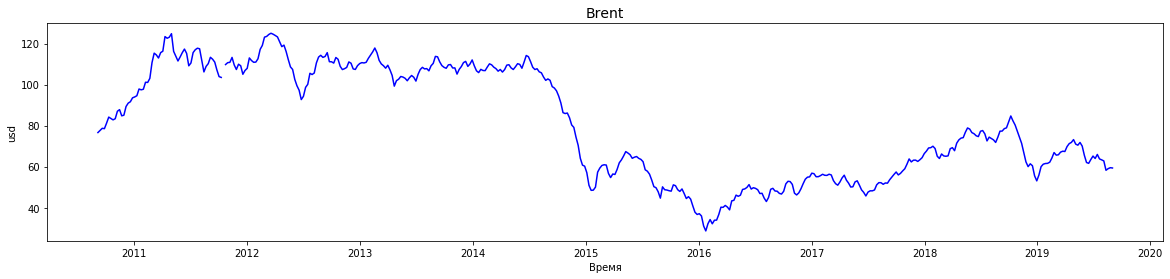

In [101]:
plt.figure(figsize =(20, 4))
plt.plot(data_w.index, data_w['Значение'], 'b' )
plt.title('Brent', size=14)
plt.xlabel('Время')
plt.ylabel('usd')
plt.show()

In [102]:
data_w = data_w[['Значение', 'year', 'month', 'quarter', 'weekofyear', 'diff_1']]

In [103]:
data_euro = euro.set_index('data').drop('cdx', axis=1)
data_usd = usd.set_index('data').drop('cdx', axis=1)

In [104]:
data_euro.head()

,curs
data,
2010-09-01,39.0127
2010-09-02,39.1654
2010-09-03,39.2901
2010-09-04,39.3505
2010-09-07,39.4720


In [105]:
data_usd.head()

,curs
data,
2010-09-01,30.8669
2010-09-02,30.8001
2010-09-03,30.6858
2010-09-04,30.6922
2010-09-07,30.5771


In [106]:
data_euro = data_euro.resample('W').mean()
data_usd = data_usd.resample('W').mean()

In [107]:
data_euro.loc[1:, 'diff_1_euro'] = data_euro['curs'][:-1].values - data_euro['curs'][1:].values
data_euro.head()

,curs,diff_1_euro
data,,
2010-09-05,39.204675,NaN
2010-09-12,39.293360,-0.088685
2010-09-19,39.977740,-0.684380
2010-09-26,41.042640,-1.064900
2010-10-03,41.351660,-0.309020


In [108]:
data_usd.loc[1:, 'diff_1_usd'] = data_usd['curs'][:-1].values - data_usd['curs'][1:].values
data_usd.head()

,curs,diff_1_usd
data,,
2010-09-05,30.76125,NaN
2010-09-12,30.79402,-0.03277
2010-09-19,30.84672,-0.05270
2010-09-26,30.99920,-0.15248
2010-10-03,30.52764,0.47156


In [109]:
data_w = pd.concat([data_w, data_usd.diff_1_usd, data_euro.diff_1_euro], axis=1)

In [110]:
data_w.head()

,Значение,year,month,quarter,weekofyear,diff_1,diff_1_usd,diff_1_euro
Дата,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,35.0,-0.065000,NaN,NaN
2010-09-12,77.673333,2010.0,9.000000,3.000000,36.0,-0.288333,-0.03277,-0.088685
2010-09-19,78.693333,2010.0,9.000000,3.000000,37.0,0.021667,-0.05270,-0.684380
2010-09-26,78.518333,2010.0,9.000000,3.000000,38.0,-0.118333,-0.15248,-1.064900
2010-10-03,81.211667,2010.0,9.333333,3.333333,39.0,-0.791667,0.47156,-0.309020


Постройте модель предсказания 1-й точки от текущей (h=1).

In [111]:
data_w.shape

(470, 8)

In [112]:
data_w.iloc[58]

Значение           NaN
year               NaN
month              NaN
quarter            NaN
weekofyear         NaN
diff_1             NaN
diff_1_usd     1.11434
diff_1_euro    0.41162
Name: 2011-10-16 00:00:00, dtype: float64

In [113]:
v1 = list((data_w.iloc[57].values + data_w.iloc[59].values) / 2)
print(v1)

[106.61666666666666, 2011.0, 10.0, 4.0, 41.0, -1.130833333333333, -0.04336000000000162, 0.10661999999999949]


In [114]:
v1_np = np.reshape(v1, (1,8))

In [115]:
data_w.iloc[58] = v1_np

In [116]:
scl_target=StandardScaler() 

h=1
target = data_w["Значение"].values[h:].reshape((data_w.shape[0]-h,1))
y = scl_target.fit_transform(target)
y.shape

(469, 1)

In [117]:
scl_x=StandardScaler() 

In [120]:
data_w_temp = data_w.iloc[:-h,:].fillna(0)

In [121]:
scl_x=StandardScaler() 

X = data_w_temp.values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(469, 8)

In [122]:
X.shape[1]

8

In [123]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

f_test, _ = f_regression(X, y.ravel())

for i in range(X.shape[1]):
    print("F-test={:.2f},  I={}".format(f_test[i],i))

F-test=65493.55,  I=0
F-test=488.25,  I=1
F-test=0.26,  I=2
F-test=0.20,  I=3
F-test=0.24,  I=4
F-test=2.31,  I=5
F-test=0.00,  I=6
F-test=0.00,  I=7


In [124]:
sfk =SelectKBest(f_regression, k=5)
X_new1 =sfk.fit_transform(X, y.ravel())
X_new1.shape

(469, 5)

In [125]:
sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())
X_new2.shape

(469, 1)

In [126]:
#Возьмем как оценщик GradientBoostingRegressor и построим новое пространство в X_new3

In [127]:
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
X_new3.shape

(469, 1)

In [128]:
[X_new1[:5,:], X_new2[:5,:],X_new3[:5,:]]

[array([[-0.15756477, -1.77410621,  0.72173368,  0.56132546, -0.12806812],
        [-0.11787695, -1.77410621,  0.72173368,  0.62780567, -0.56218025],
        [-0.07959047, -1.77410621,  0.72173368,  0.69428589,  0.0403933 ],
        [-0.08615923, -1.77410621,  0.72173368,  0.7607661 , -0.23173669],
        [ 0.0149371 , -1.77410621,  0.81947789,  0.82724631, -1.54055236]]),
 array([[-0.15756477],
        [-0.11787695],
        [-0.07959047],
        [-0.08615923],
        [ 0.0149371 ]]),
 array([[-0.15756477],
        [-0.11787695],
        [-0.07959047],
        [-0.08615923],
        [ 0.0149371 ]])]

In [129]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [0 1 2 4 5]
Номера признаков лучших признаков по процентной форме:  [0]
Номера признаков для выбора по модели :  [0]


In [130]:
X_new = X[:,[0,1,2,4,5]]

In [131]:
#тестовые и тренировочные данные

In [132]:
def split_data( data, split_date ):
    return data.iloc[:split_date,:].copy(), \
           data.iloc[split_date:,:].copy()

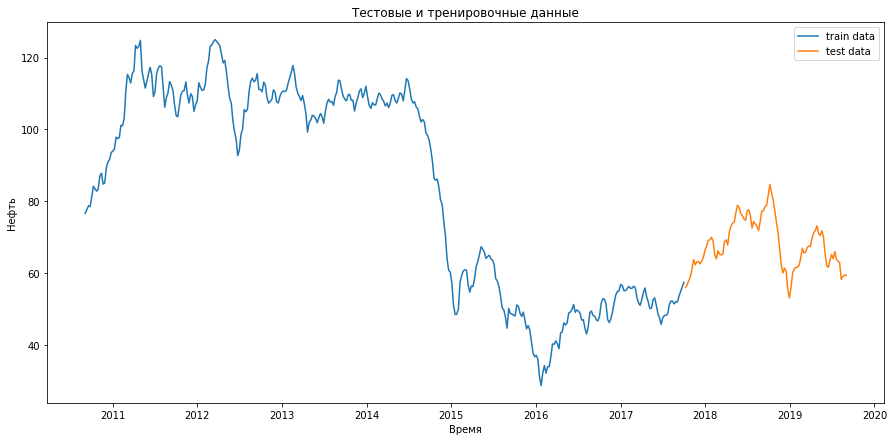

In [133]:
train, test = split_data( data_w, -100)

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Нефть')
plt.plot(train.index,train.iloc[:,0], label='train data' )
plt.plot(test.index,test.iloc[:,0], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [134]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

In [135]:
X_test.shape

(99, 5)

In [136]:
model_g = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)

In [137]:
model_g.fit( X_train, y_train )

GradientBoostingRegressor(max_depth=15, random_state=0)

In [138]:
y_test_pred_g = model_g.predict(X_test)

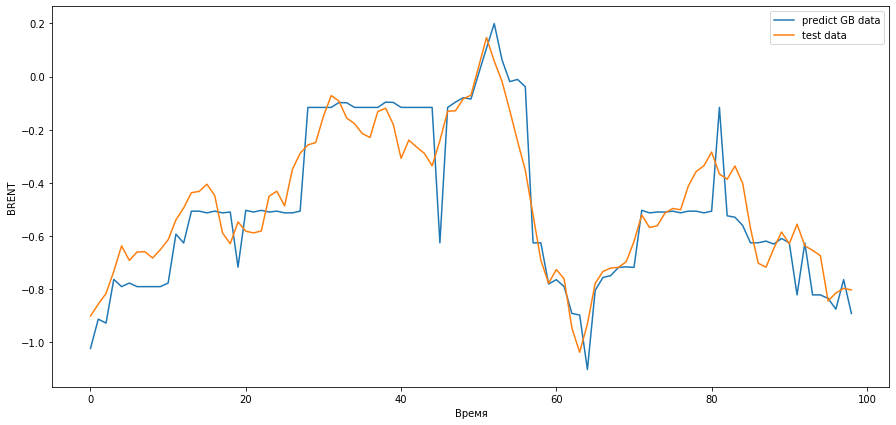

In [140]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('BRENT')
plt.plot(y_test_pred_g, label='predict GB data' )
plt.plot(y_test, label='test data')

plt.legend()
plt.show()

In [144]:
y_pred_g = model_g.predict(X_train)

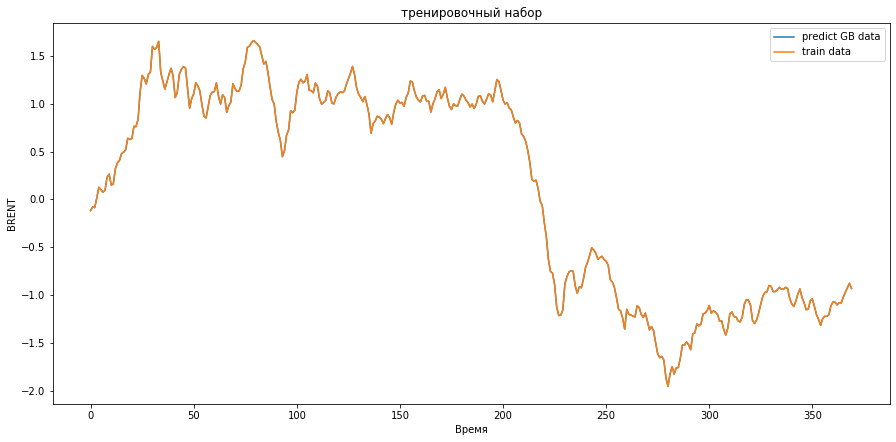

In [146]:
plt.figure( figsize=( 15, 7 ))

plt.title('тренировочный набор')
plt.xlabel('Время')
plt.ylabel('BRENT')
plt.plot(y_pred_g, label='predict GB data' )
plt.plot(y_train, label='train data')

plt.legend()
plt.show()

Градиентный бустинг не отличается от тренировочных данных на интервале обучения.

In [147]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [148]:
er_mse = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_mae = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('ошибка mse :  ', er_mse,'\nошибка mae  :  ', er_mae,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.01438269449015484 
ошибка mae  :   0.09424418373147642 
оценка R2 :   0.7796599095337008


In [149]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [150]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))

In [151]:
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   3.690302113467906 %


In [153]:
#Cнова вернемся к нашей картинке. Тюнинг параметров при выборе наилучшей модели как правило не на много улучшает общую картину. Сделаем выводы

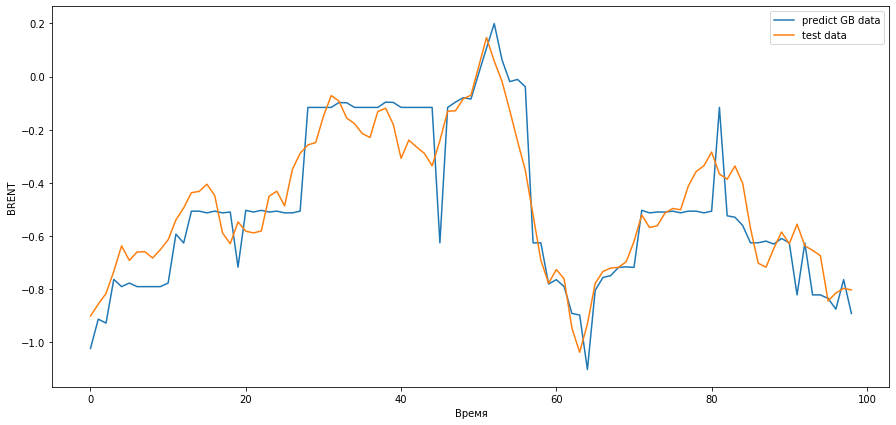

In [154]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('BRENT')
plt.plot(y_test_pred_g, label='predict GB data' )
plt.plot(y_test, label='test data')

plt.legend()
plt.show()

Выводы:
    - предиктивная модель явно запаздывает, даже на явно выраженных трендовых участках. При малейшем намеке на смене тренда возникают всплески